# Comic book reviews from *comicbookroundup.com*

## Do critics and fans agree?

Ho Fai Wong

# Agenda

1. Introduction
2. Approach
3. Analysis


# 1. Introduction

Comic book reviews on **http://comicbookroundup.com/**

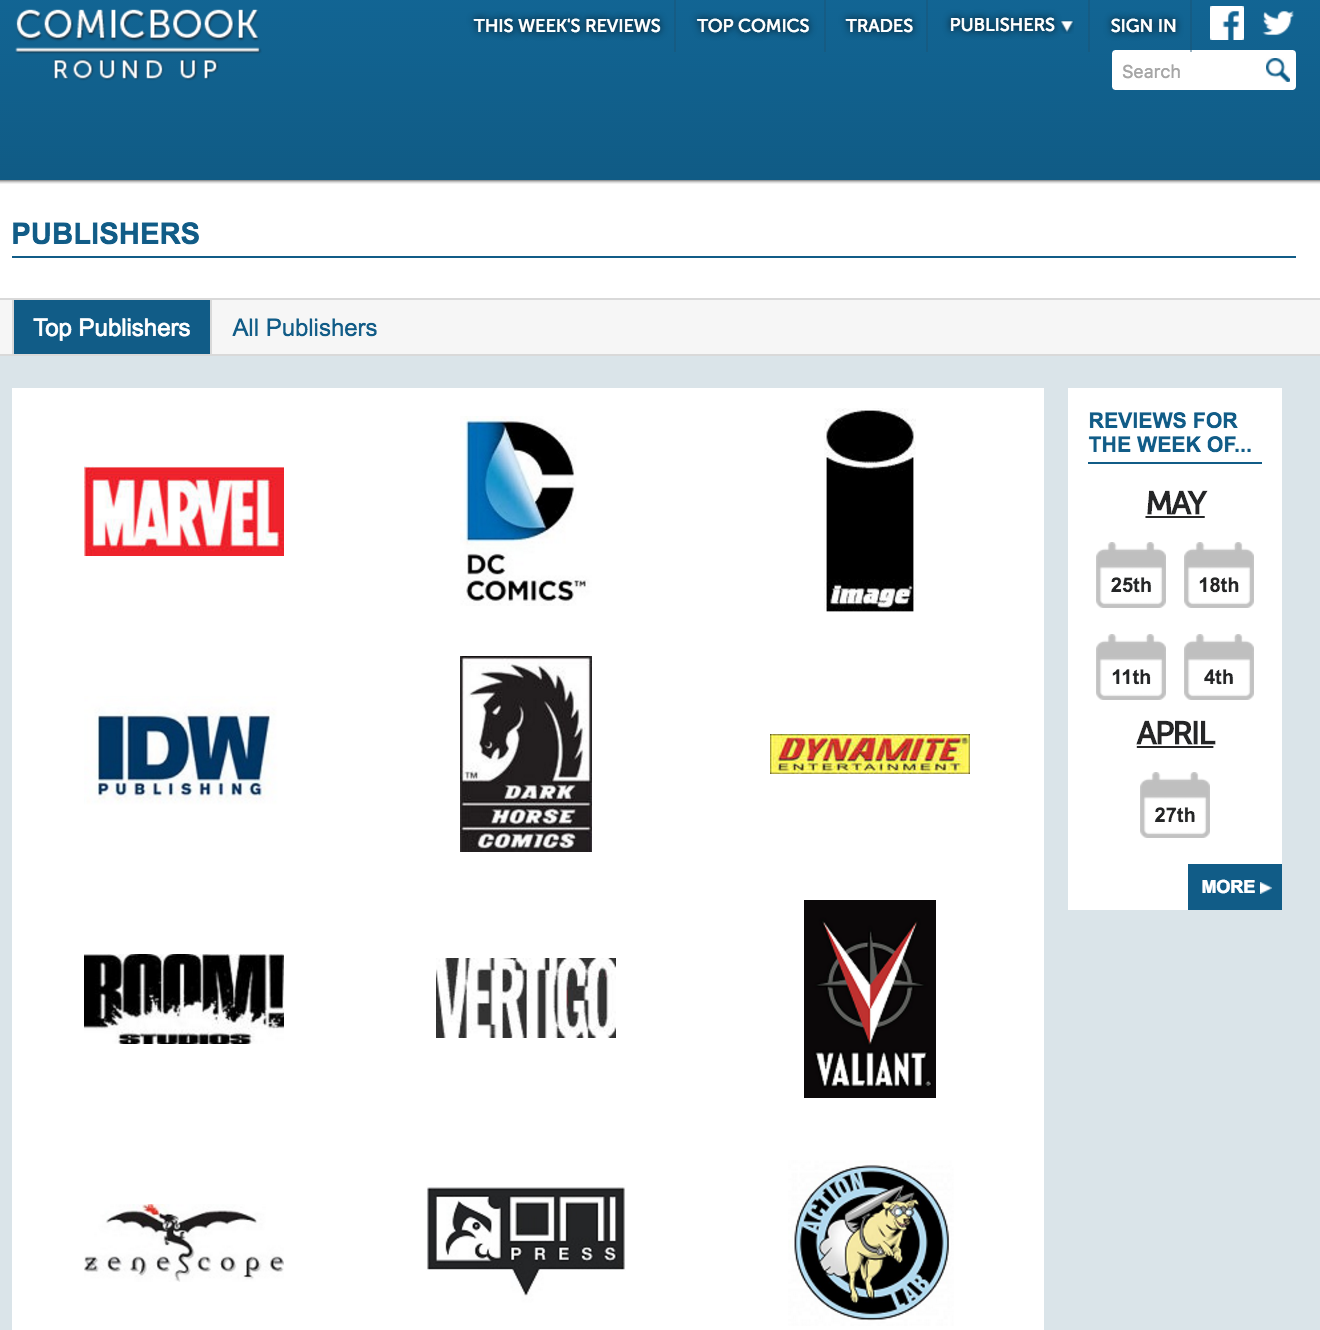

In [154]:
from IPython.display import Image
Image(filename='screenshot_main.png', embed=True)

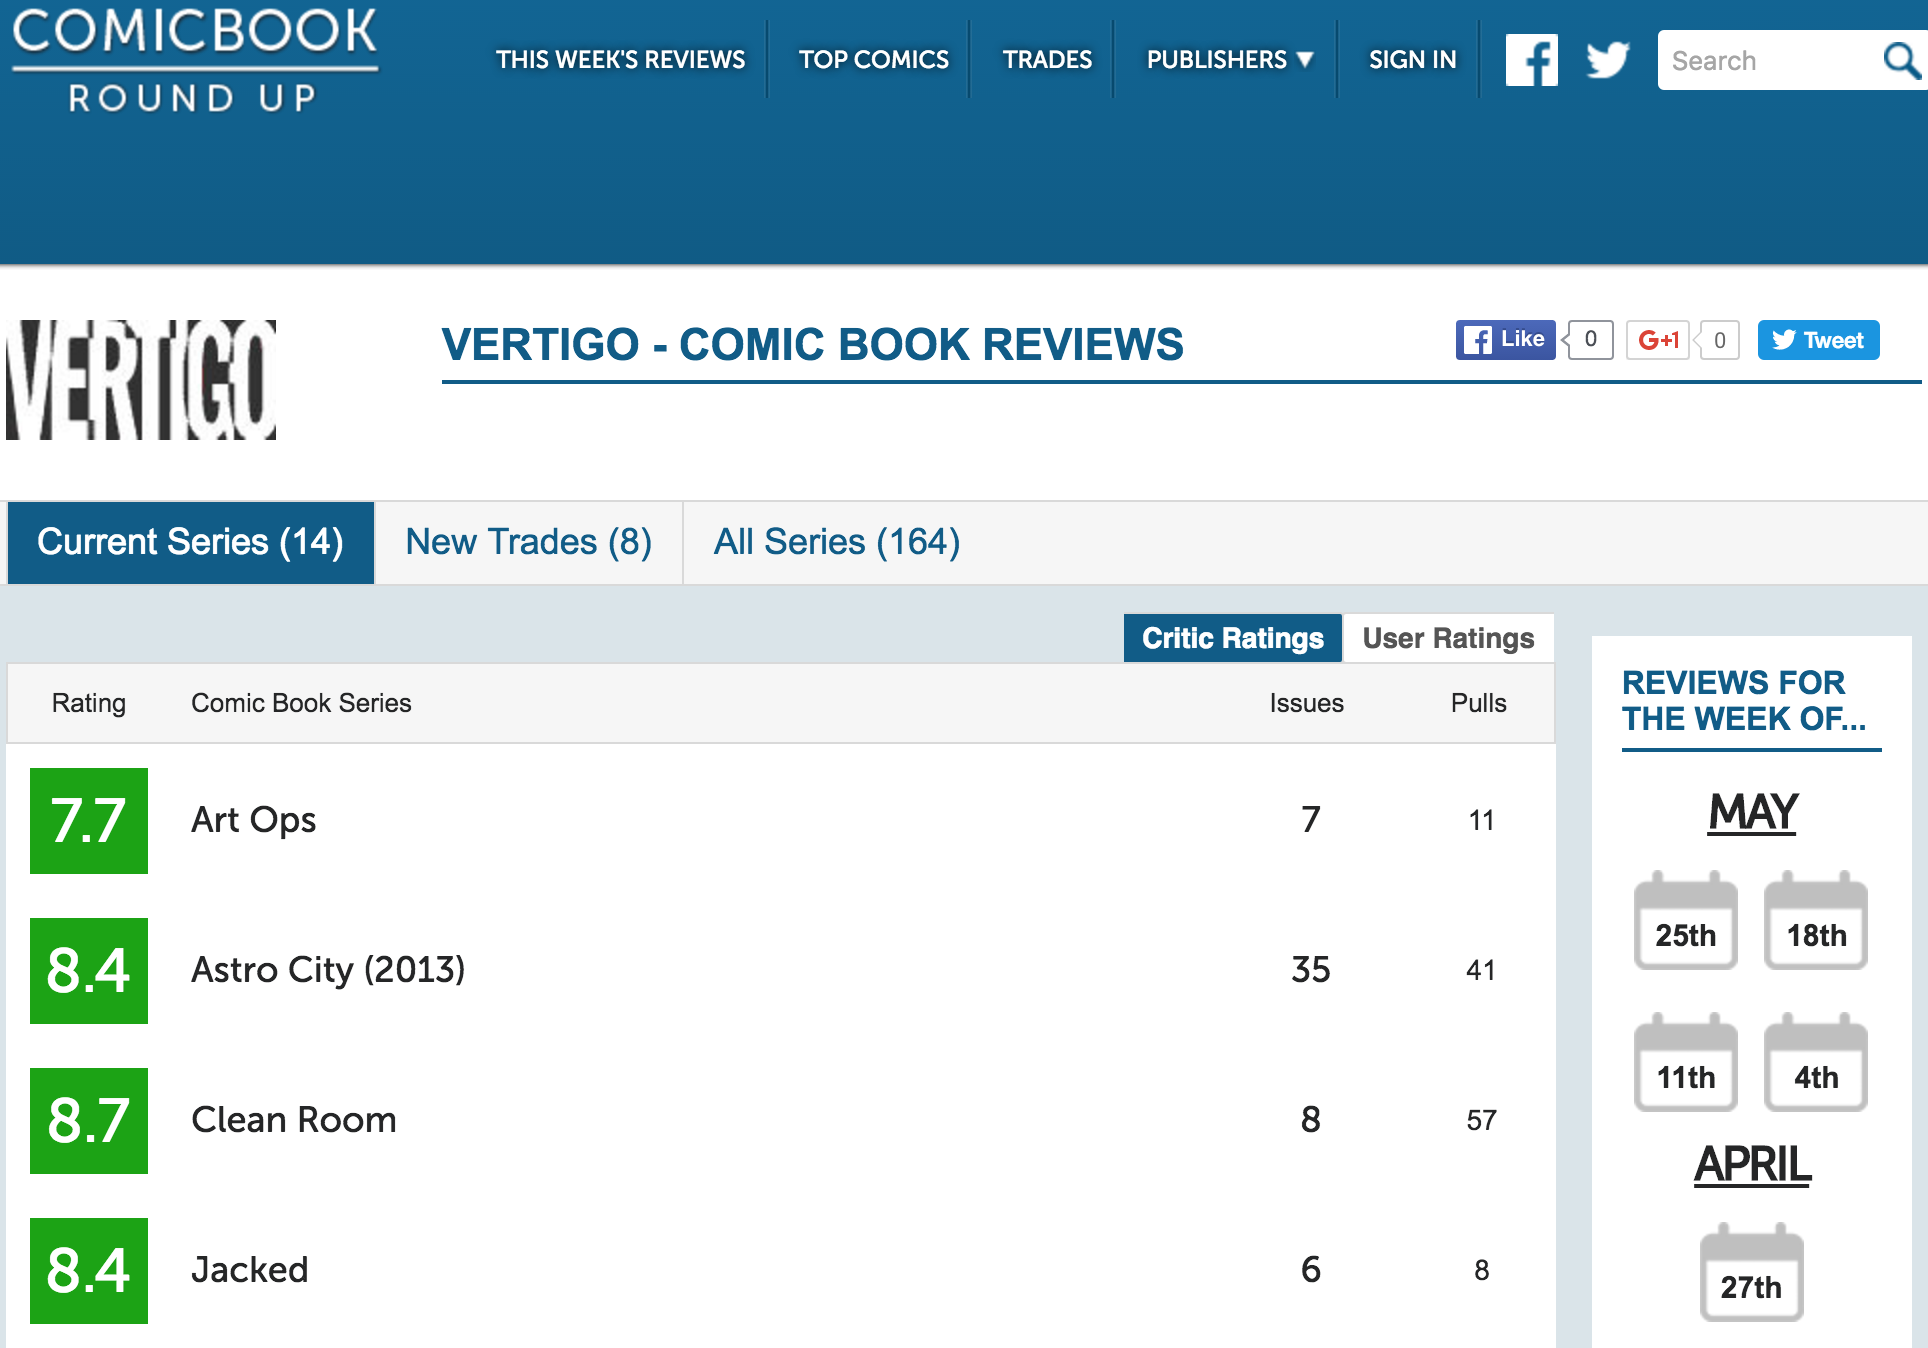

In [181]:
Image(filename='screenshot_vertigo.png', embed=True)

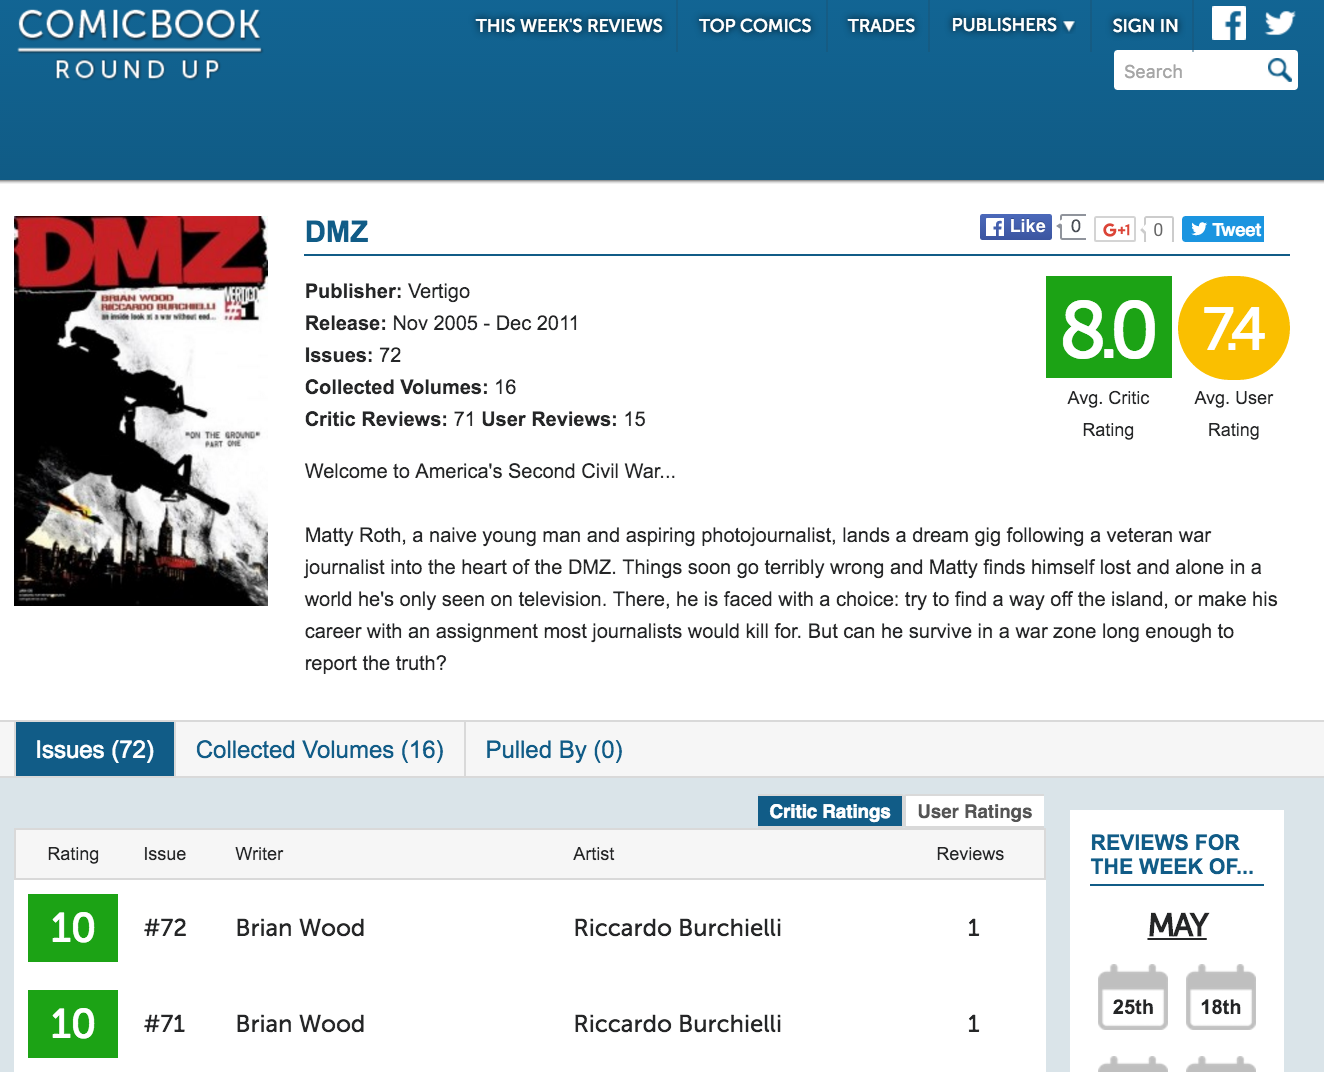

In [155]:
Image(filename='screenshot_dmz.png', embed=True)

# 2. Approach

## Step 1: Crawl with Scrapy

   1. Scrape publisher urls from main page -> **20 publishers total**
   2. For each publisher, scrape series urls -> **5,829 series total**
   3. For each series, scrape series info, issues and ratings -> **33,157 issues total**

### Get list of all publisher URLs

In [10]:
import requests
import re
from bs4 import BeautifulSoup
text = requests.get('http://comicbookroundup.com/comic-books/reviews').text
text = BeautifulSoup(text)

In [12]:
soup = text.find_all('td', class_='top-publisher')
f = open('./urls.txt', 'w')
for item in soup:
    for link in item.find_all('a'):
        f.write("%s\n" % ('http://comicbookroundup.com'+link.get('href')))
f.close()

### Web scraping: See Scrapy

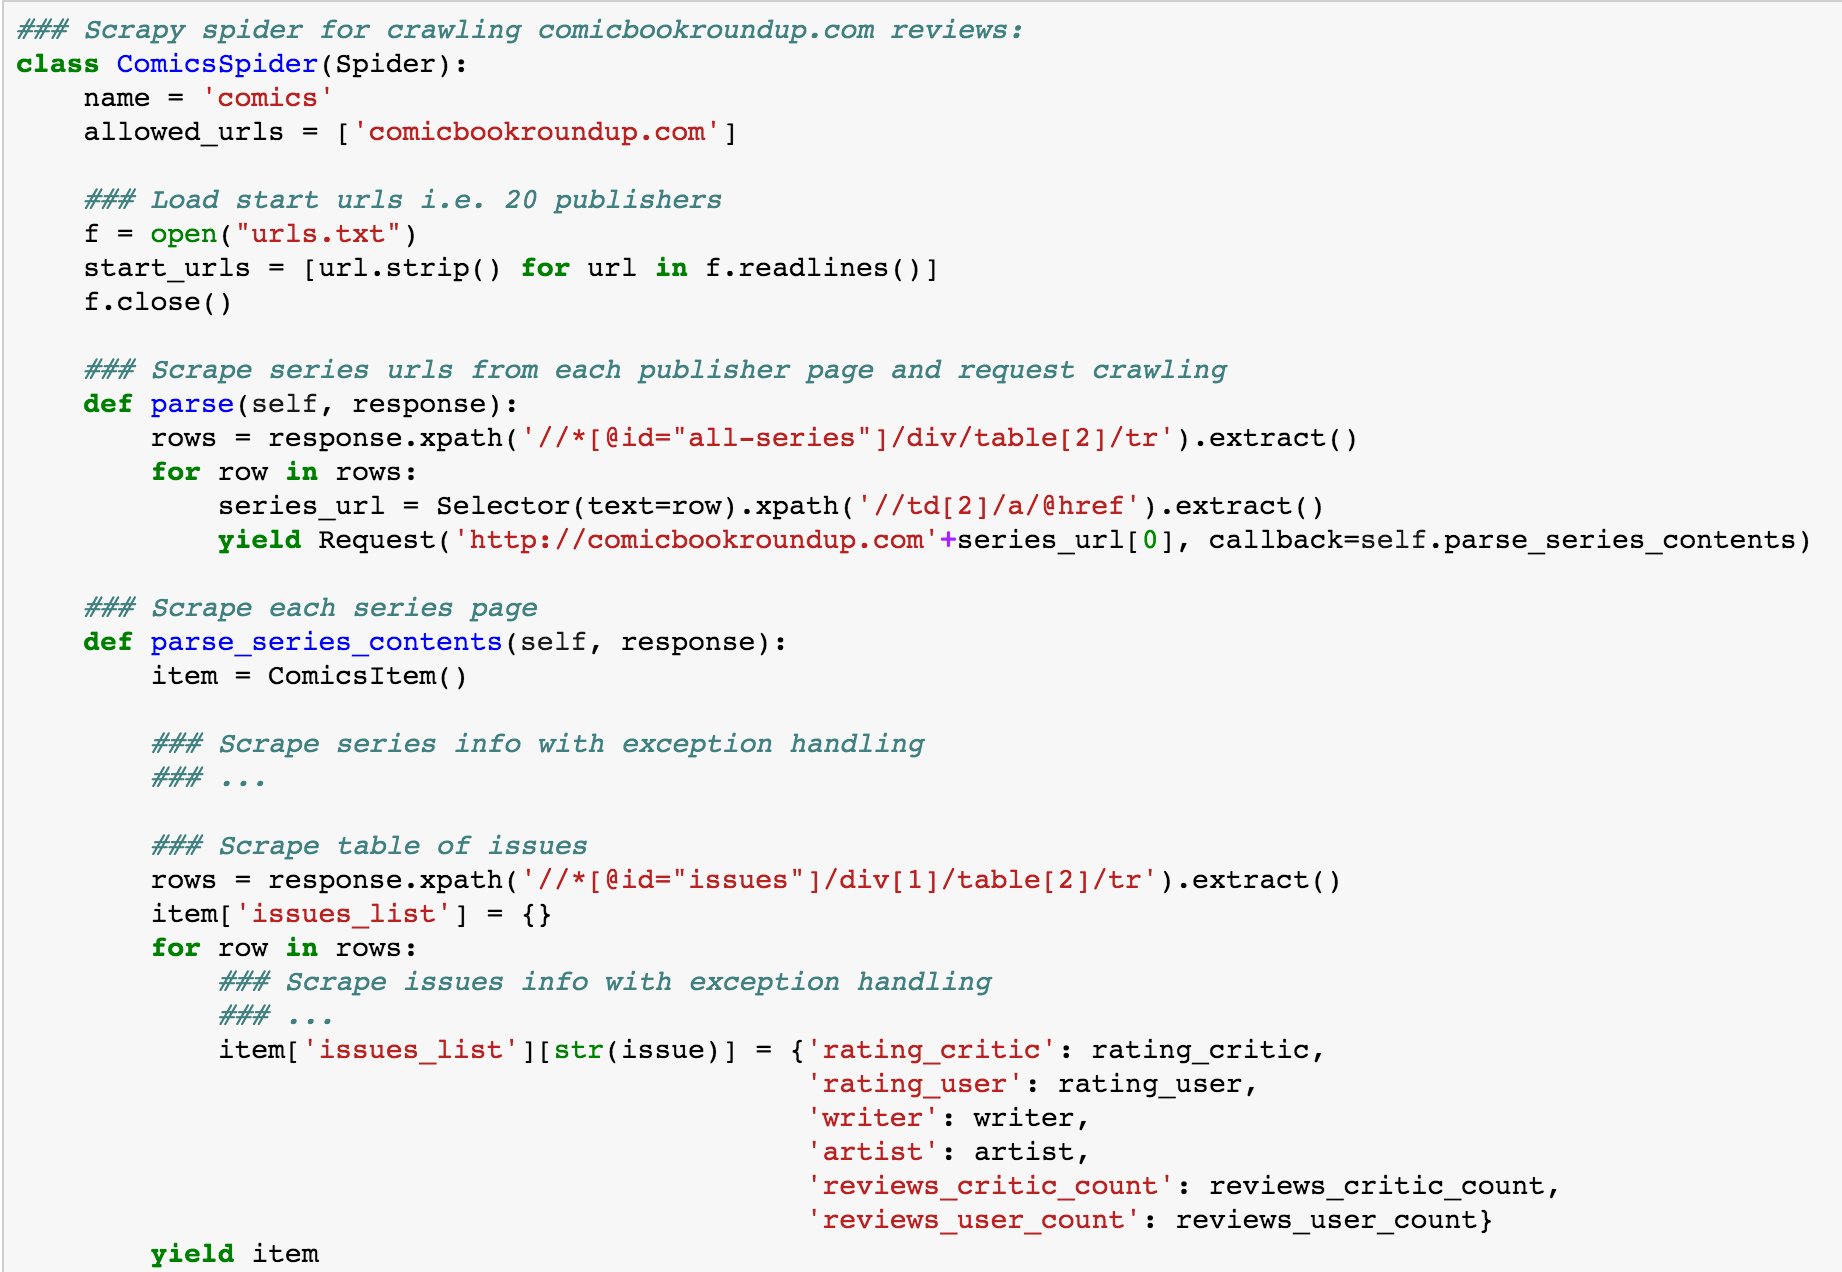

In [56]:
Image(filename='screenshot_spider.png', embed=True)

## Step 2: Pass to Jupyter Notebook

### Series data:

   1. Save **series** data to MongoDB collection
   2. Load into **series dataframe** in Jupyter Notebook

### Parsing the data

In [2]:
%pylab inline
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Import MongoDB data into Jupyter Notebook
import pymongo
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.comics
coll = db.series

In [4]:
# Create dataframe for comic series data
series_df = pd.DataFrame(list(coll.find()))
series_df.columns = ['_id', 'series_rating_critic', 'series_rating_user', 'issue_count', 'issue_dict', 'publisher',
             'series_release', 'series_name', 'series_review_cnt_critic', 'series_review_cnt_user']
series_df = series_df.drop(series_df.loc[series_df['publisher'].isnull()].index)
series_df['series_rating_diff'] = series_df['series_rating_critic'] - series_df['series_rating_user']

In [40]:
print 'Sample rows from series dataframe:'
series_df.loc[1,]

Sample rows from series dataframe:


_id                                                  573f8e927a498c61f089ae4f
series_rating_critic                                                      6.9
series_rating_user                                                        NaN
issue_count                                                                 2
issue_dict                  {u'[u'2']': {u'rating_user': None, u'artist': ...
publisher                                                       Boom! Studios
series_release                                            Mar 2012 - May 2012
series_name                                   Exile On The Planet Of The Apes
series_review_cnt_critic                                                    6
series_review_cnt_user                                                      0
series_rating_diff                                                        NaN
Name: 1, dtype: object

In [37]:
print 'Sample issue_dict:'
series_df.loc[1,].issue_dict

Sample issue_dict:


{u"[u'1']": {u'artist': u'Marc Laming',
  u'rating_critic': 6.9,
  u'rating_user': None,
  u'reviews_critic_count': 5,
  u'reviews_user_count': 0,
  u'writer': u'Corinna Bechko'},
 u"[u'2']": {u'artist': None,
  u'rating_critic': 7.0,
  u'rating_user': None,
  u'reviews_critic_count': 1,
  u'reviews_user_count': 0,
  u'writer': None}}

### Issues data:

   3. Extract **issues** data into MongoDB collection
   4. Load into **issues dataframe** in Jupyter Notebook

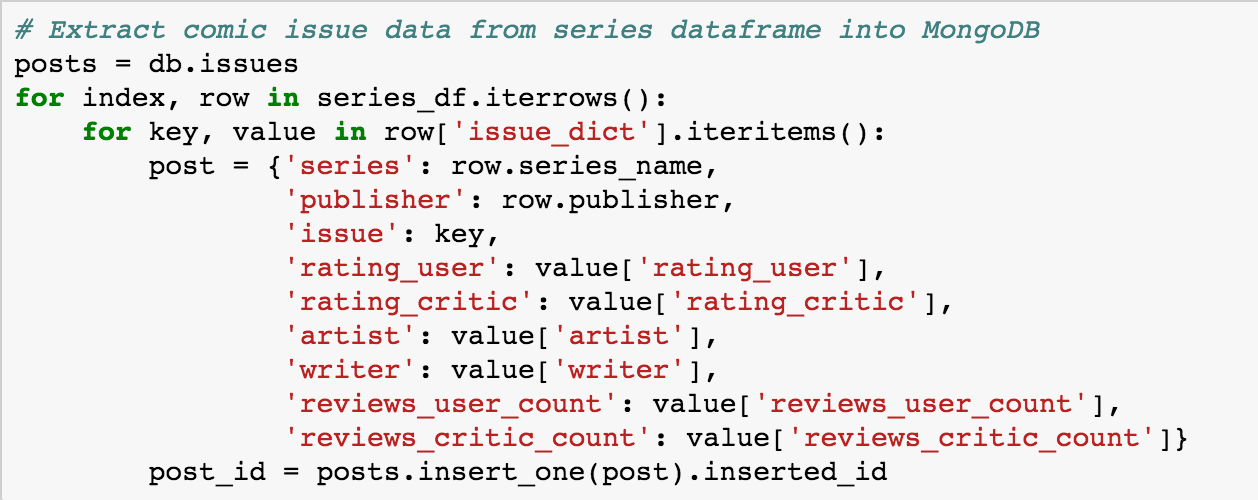

In [49]:
Image(filename='screenshot_issueDict.png', embed=True, width=600)

In [5]:
# Extract comic issue data from series dataframe into MongoDB
posts = db.issues
for index, row in series_df.iterrows():
    for key, value in row['issue_dict'].iteritems():
        post = {'series': row.series_name,
                'publisher': row.publisher,
                'issue': key,
                'rating_user': value['rating_user'],
                'rating_critic': value['rating_critic'],
                'artist': value['artist'],
                'writer': value['writer'],
                'reviews_user_count': value['reviews_user_count'],
                'reviews_critic_count': value['reviews_critic_count']}
        post_id = posts.insert_one(post).inserted_id

In [6]:
# Create dataframe for comic issue data
issues_df = pd.DataFrame(list(posts.find()))
issues_df['rating_diff'] = issues_df['rating_critic'] - issues_df['rating_user']

In [7]:
# Downselect comic issue data for top 5 publishers
issues_top_pub = issues_df[[x in ['DC Comics','Marvel Comics','Image Comics', 
                                  'Dark Horse Comics','IDW Publishing'] for x in issues_df.publisher]]

# 3. Analysis

## Issues by publisher

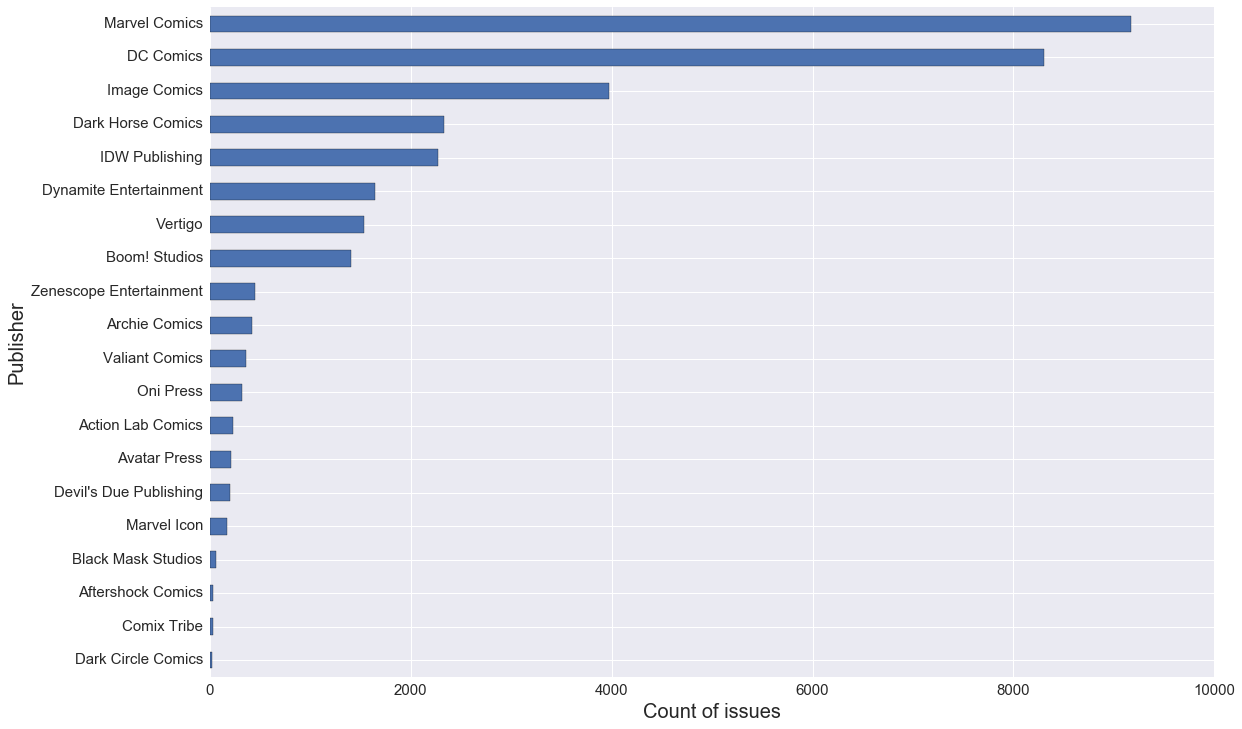

In [188]:
# Count of issues by publisher
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = 18, 12
issues_df.publisher.value_counts().plot(kind="barh").invert_yaxis()
plt.xlabel('Count of issues', fontsize = 20)
plt.ylabel('Publisher', fontsize = 20);

## Average ratings by publisher

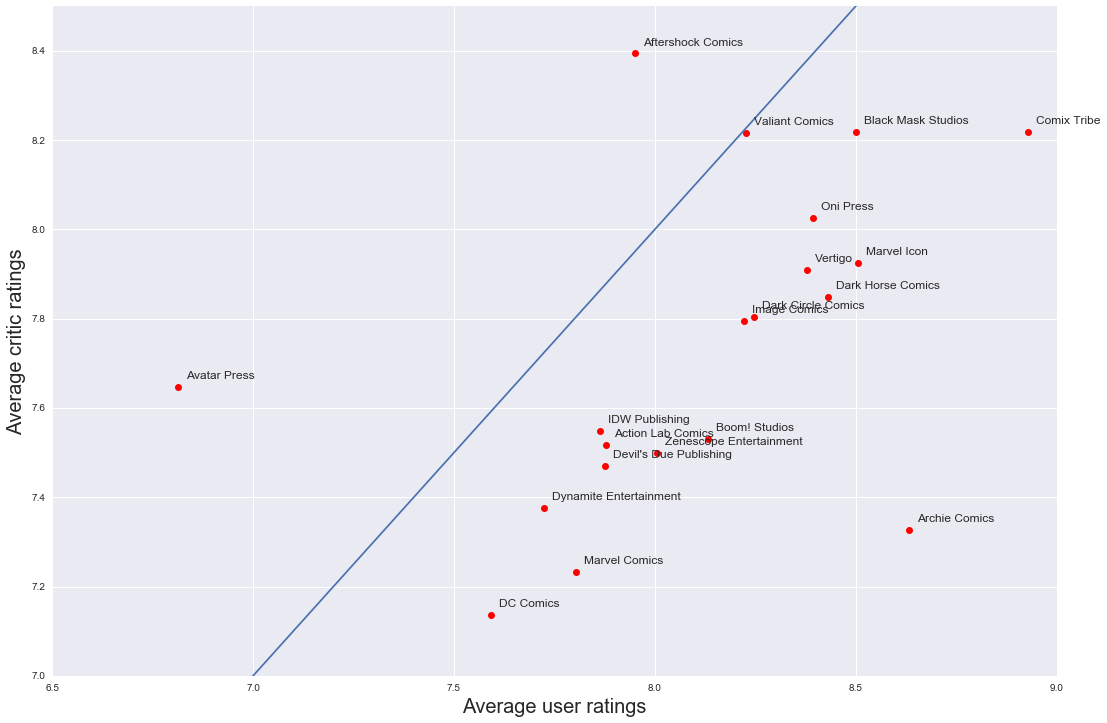

In [190]:
# Average ratings by publisher
sns.set(font_scale=1)
plt.rcParams['figure.figsize'] = 18, 12
temp = issues_df[['publisher','rating_user','rating_critic']].groupby('publisher').mean()
temp['publisher'] = temp.index
plt.plot(temp.rating_user, temp.rating_critic, 'o', color='red')
for i in range(len(temp)):
    plt.text(temp.rating_user[i] + 0.02, temp.rating_critic[i] + 0.02, temp.publisher[i])
plt.xlabel('Average user ratings', fontsize = 20)
plt.ylabel('Average critic ratings', fontsize = 20)
plt.plot( [6,10],[6,10] )
plt.xlim(6.5,9); plt.ylim(7,8.5);

## Critic vs user ratings

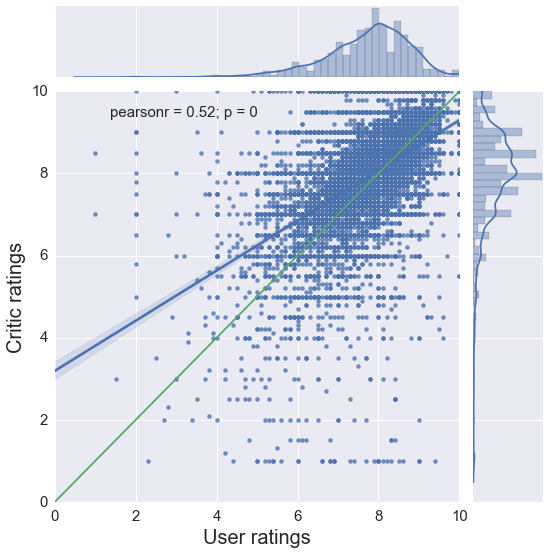

In [191]:
# Scatterplot: critic vs user ratings for all publishers
sns.set(font_scale=1.5)
sns.jointplot(issues_df.rating_critic, issues_df.rating_user, kind='reg', size=8)
plt.xlabel('User ratings', fontsize = 20)
plt.ylabel('Critic ratings', fontsize = 20)
plt.xlim(0,10); plt.ylim(0,10)
plt.plot( [0,11],[0,11] );

## Distribution of rating differences (critic - user)

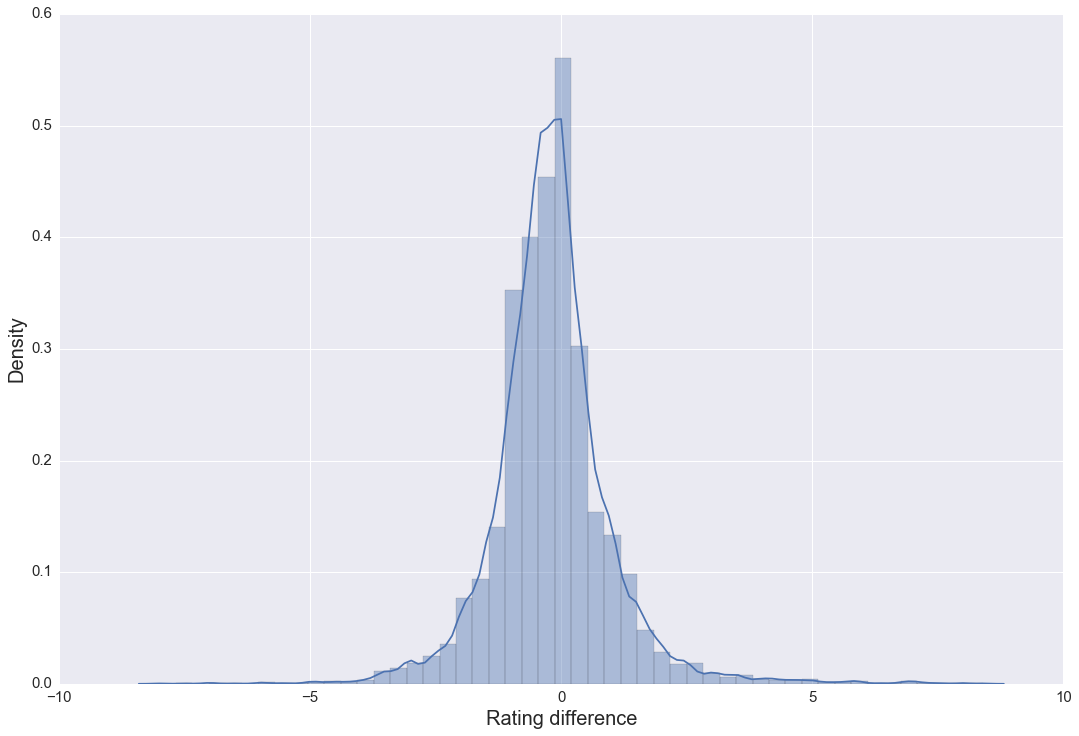

In [192]:
# Distribution of rating differences (critic - user) for all publishers
plt.rcParams['figure.figsize'] = 18, 12
sns.distplot(issues_df['rating_diff'].dropna())
plt.xlabel('Rating difference', fontsize = 20)
plt.ylabel('Density', fontsize = 20);

## Correlation between ratings and reviews

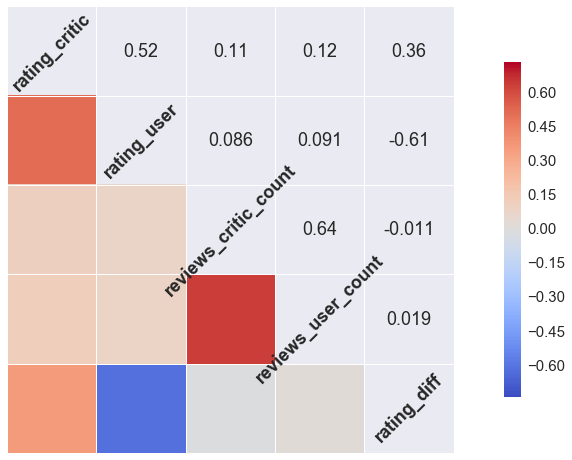

In [193]:
plt.rcParams['figure.figsize'] = 18, 8
sns.corrplot(issues_df);

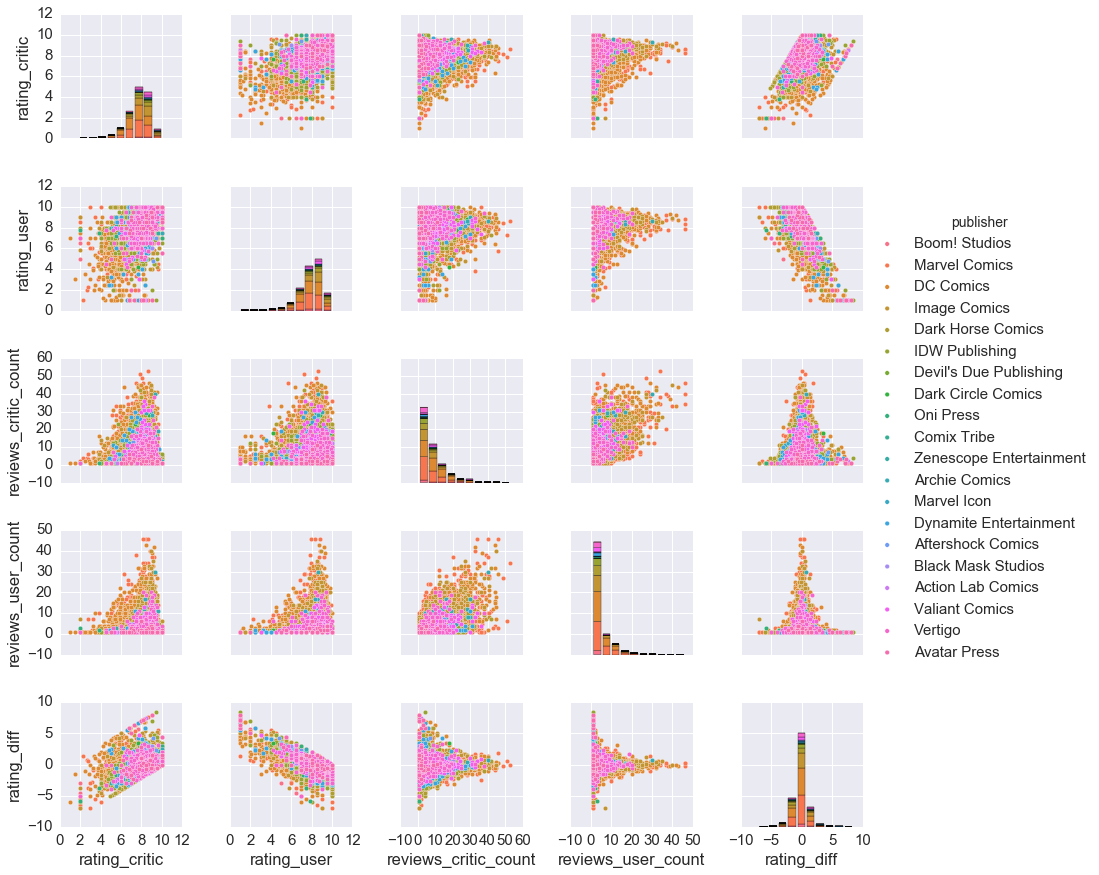

In [194]:
plt.rcParams['figure.figsize'] = 18, 6
sns.pairplot(issues_df.dropna(), hue='publisher');

## Focus on top publishers

In [132]:
# Create dataframe to compare ratings by publisher
critic = issues_top_pub[['publisher','rating_critic']]
critic.columns = ['publisher', 'rating']
critic['rater'] = 'critic'

user = issues_top_pub[['publisher','rating_user']]
user.columns = ['publisher', 'rating']
user['rater'] = 'user'

result = pd.concat([critic,user])

/Users/hofaiwong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/hofaiwong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


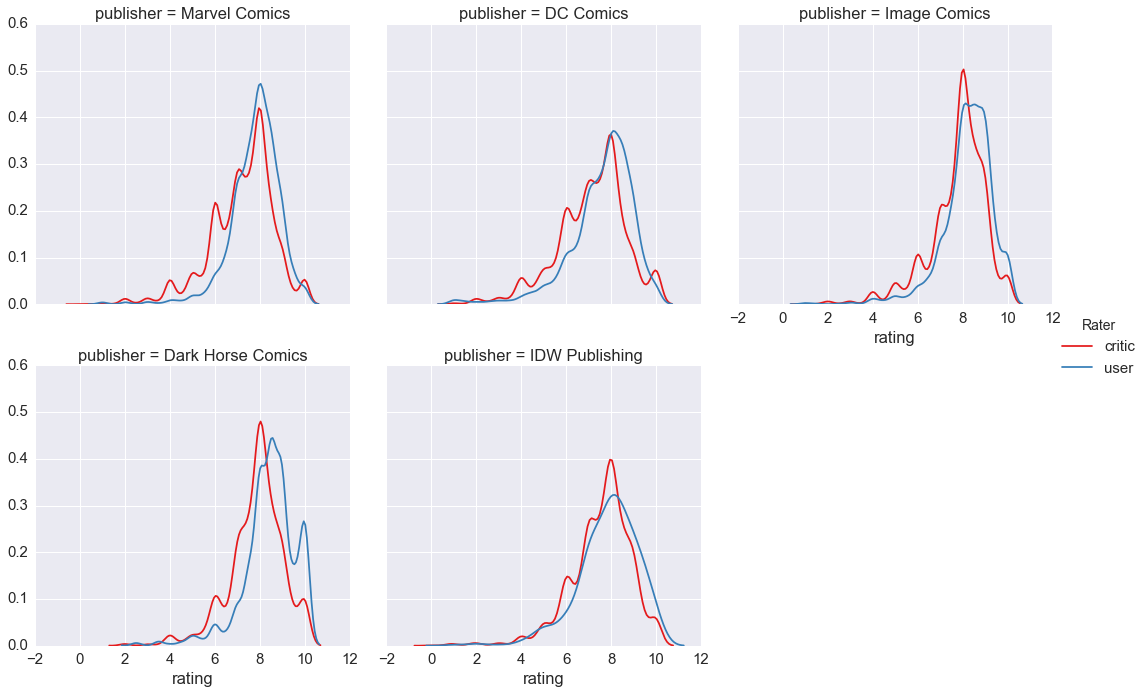

In [195]:
# Plot density of critic vs user ratings by publisher
g = sns.FacetGrid(result, col="publisher", hue="rater", palette="Set1", col_wrap=3, size=5)
g.map(sns.kdeplot, "rating", shade=False)
g.add_legend(title='Rater');

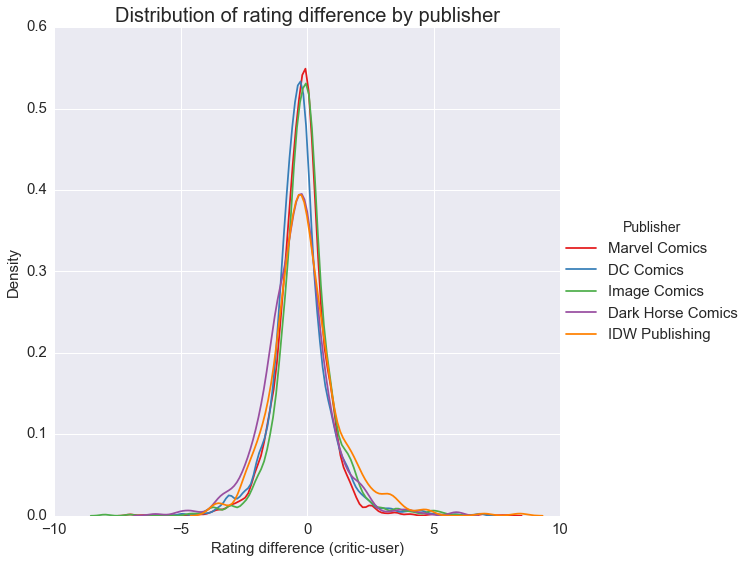

In [197]:
g = sns.FacetGrid(issues_top_pub, hue="publisher", palette="Set1", size=8)
g.map(sns.kdeplot, "rating_diff", shade=False)
g.add_legend(title='Publisher')
plt.title('Distribution of rating difference by publisher', fontsize=20)
plt.xlabel('Rating difference (critic-user)', fontsize=15)
plt.ylabel('Density', fontsize=15);

# Conclusion

 * Overall, critic and user ratings are in line and rate comics ~6-9
 * Critics are slightly more discerning than users
 * Critics hesitate less to rate a comic very low
 * A comic's rating and number of reviews are not highly correlated
 * Comics with large rating differences between critics and users were usually rated by very few users
 

# Potential future steps

 * Build Shiny application
    * Search for best reviewed titles, writers and artists
    * Find outliers (e.g. series, writers, artists, issues with largest rating_diff)
 * Scrape reviews and build word clouds

# Appendix

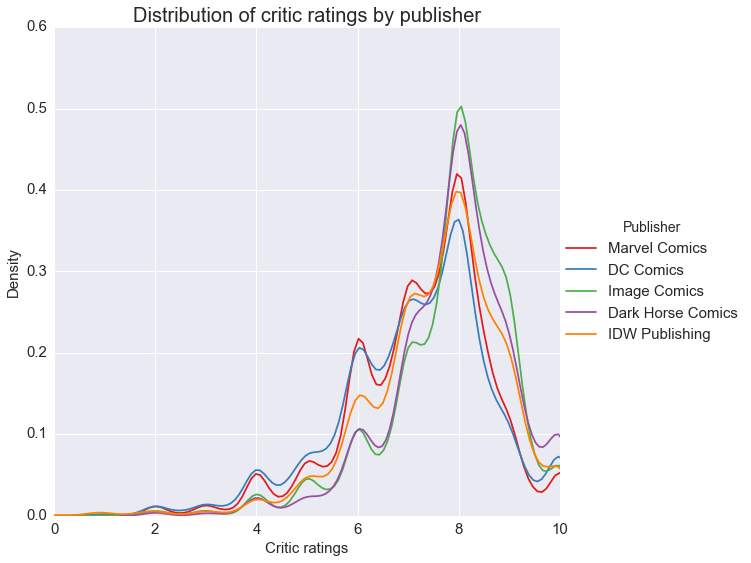

In [198]:
# Distribution of critic ratings by publisher
g = sns.FacetGrid(issues_top_pub, hue="publisher", palette="Set1", size=8)
g.map(sns.kdeplot, "rating_critic", shade=False)
g.add_legend(title='Publisher')
plt.title('Distribution of critic ratings by publisher', fontsize=20)
plt.xlabel('Critic ratings', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xlim(0,10);

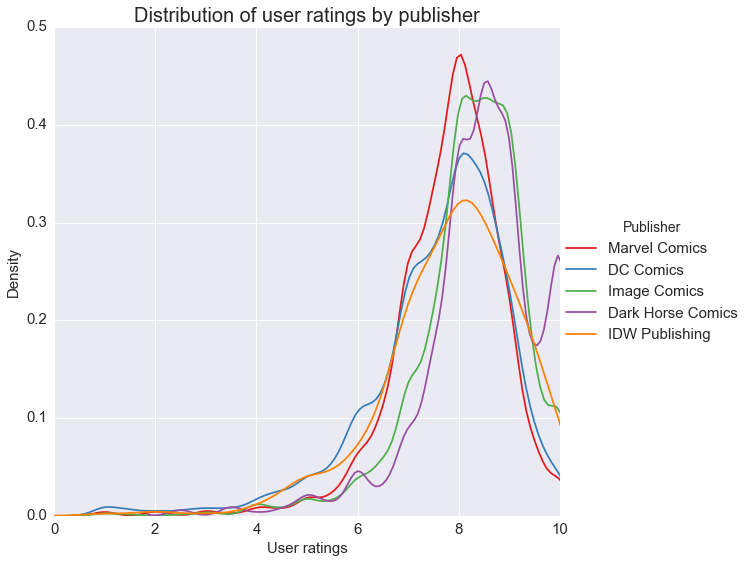

In [199]:
# Distribution of user ratings by publisher
g = sns.FacetGrid(issues_top_pub, hue="publisher", palette="Set1", size=8)
g.map(sns.kdeplot, "rating_user", shade=False)
g.add_legend(title='Publisher')
plt.title('Distribution of user ratings by publisher', fontsize=20)
plt.xlabel('User ratings', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xlim(0,10);

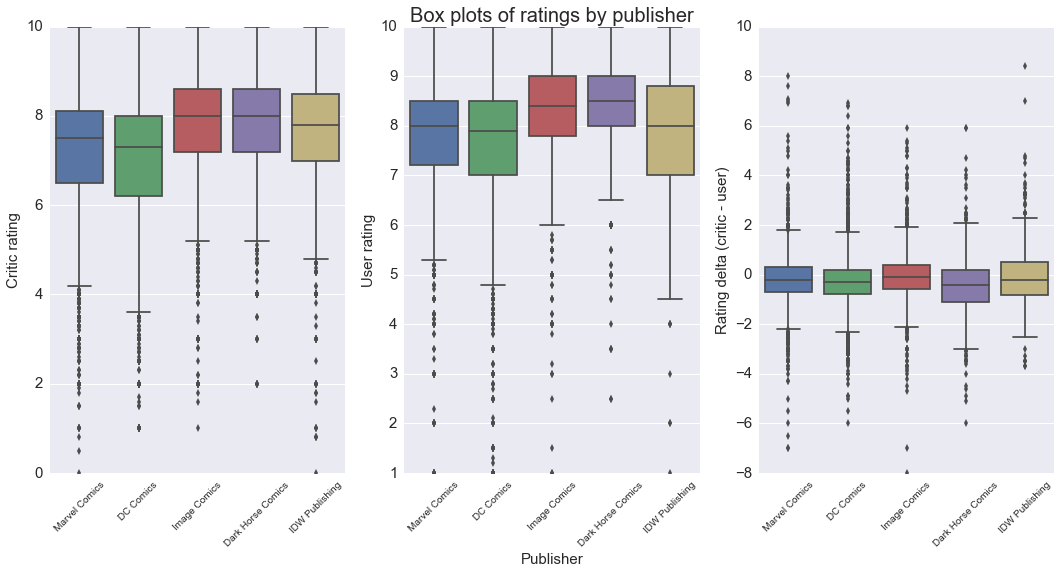

In [200]:
# Box plots of ratings by publisher
plt.rcParams['figure.figsize'] = 18, 8
plt.subplot(131)
sns.boxplot(x='publisher', y='rating_critic', data=issues_top_pub)
plt.xticks(fontsize=10,rotation=45)
plt.xlabel('', fontsize = 15)
plt.ylabel('Critic rating', fontsize = 15)
plt.subplot(132)
sns.boxplot(x='publisher', y='rating_user', data=issues_top_pub)
plt.xticks(fontsize=10,rotation=45)
plt.xlabel('Publisher', fontsize = 15)
plt.ylabel('User rating', fontsize = 15)
plt.title('Box plots of ratings by publisher', fontsize=20)
plt.subplot(133)
sns.boxplot(x='publisher', y='rating_diff', data=issues_top_pub)
plt.xticks(fontsize=10,rotation=45)
plt.xlabel('', fontsize = 15)
plt.ylabel('Rating delta (critic - user)', fontsize = 15);